In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import pathlib
from soilgasflux_fcs import json_reader
import scipy.optimize as op
from lmfit import Model

In [2]:
data_path = pathlib.Path('../data/synthetical/data62/test')
a = json_reader.Initializer(folderPath=data_path)
df = a.prepare_rawdata()
for i in df['id'].unique():
    df_i = df[df['id'] == i]

In [3]:
data_path = pathlib.Path('/Users/alexnaokiasatokobayashi/Documents/FCS/raw_data/temp')
a = json_reader.Initializer(folderPath=data_path)
df = a.prepare_rawdata()
for i in df['id'].unique():
    print(i)
    df_i = df[df['id'] == i]
    

2025-5-8_16-40-56


In [4]:
def target_function(t, cx, a, c0,t0):
    e = 2.71828
    return cx+(c0-cx)*e**(-a*(t-t0))

<Axes: xlabel='timedelta', ylabel='k30_co2'>

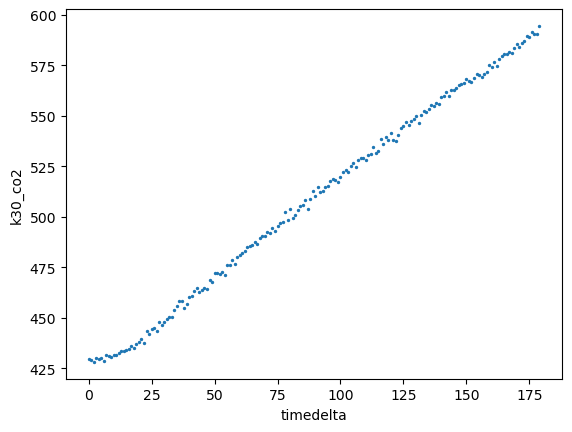

In [5]:
df_i.plot.scatter(x='timedelta', y='k30_co2',s=2)

In [6]:
df_i['k30_co2'].values[0]

429.60555565400176

In [7]:
fmodel = Model(target_function)
c0 = df_i['k30_co2'].values[0]
params = fmodel.make_params(cx=c0, a=0.1, c0=c0, t0=0.001)
params['c0'].vary = False
params['a'].min=0

deadband = 30
cutoff= 90

result = fmodel.fit(df_i['k30_co2'].values[deadband:cutoff], 
                    params, t=df_i['timedelta'].values[deadband:cutoff])
# result

/Users/alexnaokiasatokobayashi/.local/share/mamba/envs/FCS/lib/python3.9/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [8]:
# def hm_model_dcdt(t0, c0, a, cx, t):
#     e = 2.71828
#     dcdt = a*(cx - c0)*e**(-a*(t-t0))
#     return dcdt

In [9]:
def hm_model_dcdt(c0, a, cx,t0, t):
    e = 2.71828
    dcdt = a*(cx - c0)*e**(-a*(t-t0))
    return dcdt

In [10]:
def lnlike(theta, t, y, yerr, c0):
    cx, a,t0= theta
    model = cx + (c0-cx)*2.71828**(-a*(t-t0))
    
    return -0.5*(np.sum((y-model)**2/yerr**2) +  np.sum(np.log(yerr**2)))#+len(y)*np.log(2*np.pi)

def lnprior(theta, cx_bf, a_bf,t0_bf):
    cx, a,t0 = theta

    if cx_bf*0.01 < cx < cx_bf*100 and 0 < a < a_bf*100 and t0 > 0:
        return 0.0
    return -np.inf

def lnprob(theta, t, y, yerr, c0, cx_bf, a_bf,t0_bf):  
    lp = lnprior(theta, cx_bf, a_bf, t0_bf)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, t, y, yerr, c0)

In [11]:
ndim, nwalkers = 3, 10
pos = np.array([[result.params['cx'].value], 
                [result.params['a'].value], [1]]).reshape(1,3)+1e-4*np.random.randn(nwalkers, ndim)
# pos

In [38]:
ndim, nwalkers = 3, 100

cx_bf = result.params['cx'].value
a_bf = result.params['a'].value
t0_bf = result.params['t0'].value

pos_cx = np.exp(np.random.uniform(low=np.log(cx_bf*1e-1), high=np.log(cx_bf*1e1), size=(nwalkers,1)))
pos_a = np.exp(np.random.uniform(low=np.log(a_bf*1e-1), high=np.log(a_bf*1e1), size=(nwalkers,1)))
pos_t0 = np.random.uniform(low=0.001, high=10, size=(nwalkers,1))

# gaussian distribution
# pos_cx = np.ones((nwalkers, 1)) * cx_bf + np.random.normal(0, cx_bf*10, (nwalkers, 1))
# pos_a = np.ones((nwalkers, 1)) * a_bf + np.random.normal(0, a_bf*10, (nwalkers, 1))

pos = np.concatenate((pos_cx, pos_a, pos_t0), axis=1)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnprob, args=(df_i['timedelta'].values[deadband:cutoff],
                                  df_i['k30_co2'].values[deadband:cutoff],
                                  np.ones(cutoff-deadband)*1.5,
                                  430,
                                  cx_bf,
                                  a_bf,
                                  t0_bf))
nsteps = 15000
sampler.run_mcmc(pos, nsteps)

State([[1.83864654e+03 7.58796948e-04 1.20809046e+01]
 [1.20068575e+03 1.41908463e-03 1.25574417e+01]
 [8.09675994e+02 3.09018085e-03 1.36042676e+01]
 [2.58301197e+03 4.85082576e-04 1.11979368e+01]
 [7.83378435e+02 3.40038292e-03 1.42072542e+01]
 [1.34282967e+03 1.20956198e-03 1.26438974e+01]
 [9.31262007e+02 2.29140440e-03 1.39448079e+01]
 [5.31734366e+02 1.94589809e-02 2.17523054e+01]
 [7.62621540e+02 3.70865083e-03 1.53728112e+01]
 [1.67505039e+03 8.53271669e-04 1.15031700e+01]
 [4.26378311e+03 2.70742905e-04 1.11749863e+01]
 [1.30785477e+04 8.15425148e-05 1.13238609e+01]
 [7.55878380e+02 3.73883057e-03 1.47972609e+01]
 [1.54247081e+03 9.69313725e-04 1.21418991e+01]
 [1.14301683e+03 1.54161788e-03 1.23577525e+01]
 [1.24202060e+03 1.36771181e-03 1.31379950e+01]
 [1.72548336e+03 8.27287035e-04 1.21594743e+01]
 [1.52891276e+03 9.81897448e-04 1.19552313e+01]
 [1.40122593e+03 1.13349425e-03 1.27450488e+01]
 [3.02297108e+03 4.05614159e-04 1.16895665e+01]
 [8.24519005e+02 2.93331295e-03 1.

In [39]:
print(cx_bf, a_bf)

1020.0009200524812 0.0019171636351060783


In [40]:
pos_cx[(pos_cx < cx_bf*0.01) | (pos_cx > cx_bf*100)]

array([], dtype=float64)

In [41]:
pos_a[(pos_a<a_bf*1e-1)|(pos_a>a_bf*1e1)]

array([], dtype=float64)

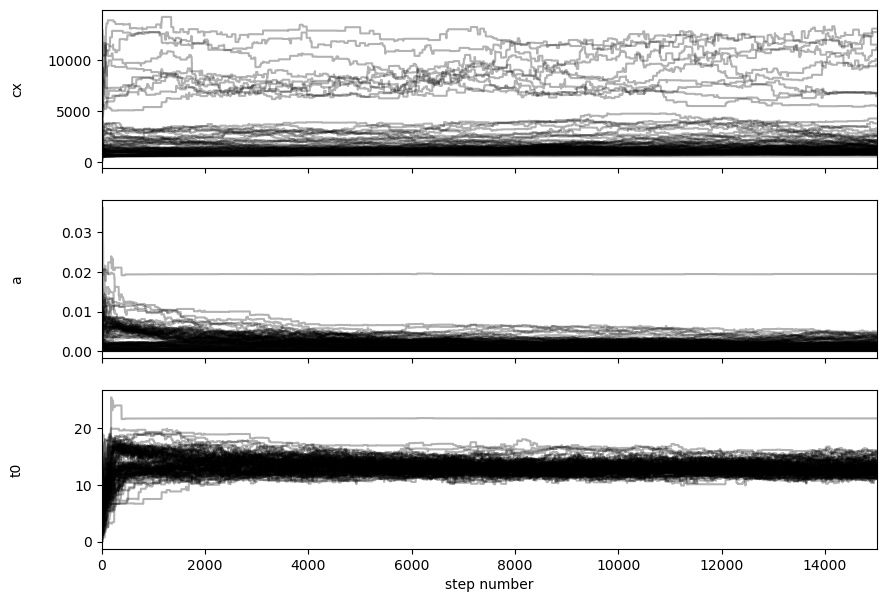

In [42]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["cx", "a", "t0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # ax.set_yscale('log')

axes[-1].set_xlabel("step number");

In [43]:
flat_samples = sampler.get_chain(discard=int(nsteps*.7), thin=15, flat=True)

In [44]:
sampler.get_autocorr_time(discard=int(nsteps*.7))

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 90;
tau: [505.09602488 510.06970907 394.01132237]

dcdt_bf 1.034527392510474
dcdt_mcmc_sampled 1.0342998201144313


/var/folders/92/kgbg9kx56kzdvzzmyn2vvmym0000gn/T/ipykernel_36914/1248097557.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


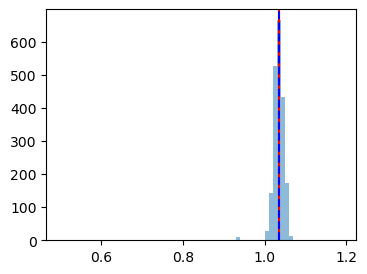

In [19]:
dcdt_bf = hm_model_dcdt(c0=430, 
                        a=result.params['a'].value, 
                        cx=result.params['cx'].value, 
                        t0=result.params['t0'].value,
                        t=np.median(df_i['timedelta'].values[deadband:cutoff]))

random_index = np.random.choice(len(flat_samples), size=2000)
# sampled_cx = np.random.choice(flat_samples[:, 0], size=3000)
# sampled_a = np.random.choice(flat_samples[:, 1], size=3000)

sampled_cx = flat_samples[random_index, 0]
sampled_a = flat_samples[random_index, 1]
sampled_t0 = flat_samples[random_index, 2]

# dcdt_mcmc = hm_model_dcdt(c0=430, a=flat_samples[:, 1], cx=flat_samples[:, 0], t=df_i['timedelta'].values.max())
dcdt_mcmc_sampled = hm_model_dcdt(c0=430, 
                                  a=sampled_a, 
                                  cx=sampled_cx, 
                                  t0=sampled_t0,
                                  t=np.median(df_i['timedelta'].values[deadband:cutoff]))

print('dcdt_bf', dcdt_bf)
print('dcdt_mcmc_sampled', np.median(dcdt_mcmc_sampled))

fig, ax = plt.subplots(1,1, figsize=(4, 3))

ax.axvline(x=dcdt_bf, color='r', label='dcdt_bf')
ax.axvline(x=np.median(dcdt_mcmc_sampled), color='b', label='dcdt_mcmc_sampled', linestyle='--')
ax.hist(dcdt_mcmc_sampled, alpha=0.5,label='dcdt_mcmc', bins=(np.arange(0.5, 1.2, 0.01)))

# ax.set_xlim(-0.5, 1.5)
fig.show()